In [1]:
pip install moviepy opencv-python numpy tensorflow scikit-learn flask

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import numpy as np
import cv2
from moviepy.editor import VideoFileClip
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
from datetime import datetime
import shutil

In [4]:
# Create necessary directories
def create_directories():
    directories = [
        '../processed_dataset/real',
        '../processed_dataset/fake',
        '../models',
        '../models/checkpoints',
        '../logs',
        '../logs/training_history',
        '../evaluation'
    ]
    for dir in directories:
        os.makedirs(dir, exist_ok=True)

In [5]:
create_directories()

In [4]:
class VideoFrameExtractor:
    def __init__(self, sample_rate=30):
        self.sample_rate = sample_rate
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )

    def extract_faces_from_frame(self, frame):
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(
            gray,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(30, 30)
        )
        if len(faces) == 0:
            return None

        processed_faces = []
        for (x, y, w, h) in faces:
            face = frame[y:y + h, x:x + w]
            face = cv2.resize(face, (128, 128))
            processed_faces.append(face)
        return processed_faces

    def process_video(self, video_path, output_dir):
        """Extract frames from a video and save them as images"""
        try:
            clip = VideoFileClip(video_path)
            for i, frame in enumerate(clip.iter_frames()):
                if i % self.sample_rate == 0:
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
                    faces = self.extract_faces_from_frame(frame)
                    if faces:
                        for j, face in enumerate(faces):
                            face_path = os.path.join(output_dir, f"{os.path.basename(video_path)}_{i}_{j}.jpg")
                            cv2.imwrite(face_path, face)
            clip.close()
        except Exception as e:
            print(f"Error processing video {video_path}: {e}")
            

In [1]:
def prepare_dataset(real_dir='../dataset/real_videos', fake_dir='../dataset/fake_videos'):
    """Prepare dataset and save frames to disk"""
    extractor = VideoFrameExtractor(sample_rate=30)
    # Process real videos
    print("Processing real videos...")
    for video in os.listdir(real_dir):
        video_path = os.path.join(real_dir, video)
        output_dir = '../processed_dataset/real'
        extractor.process_video(video_path, output_dir)

    # Process fake videos
    print("\nProcessing fake videos...")
    for video in os.listdir(fake_dir):
        video_path = os.path.join(fake_dir, video)
        output_dir = '../processed_dataset/fake'
        extractor.process_video(video_path, output_dir)

# Start from here

In [7]:
# Prepare dataset
print("Starting dataset preparation...")
prepare_dataset()

Starting dataset preparation...
Processing real videos...

Processing fake videos...


KeyboardInterrupt: 

In [9]:
# Split dataset into training and validation
all_real_files = os.listdir('../processed_dataset/real')
all_fake_files = os.listdir('../processed_dataset/fake')
real_train, real_val = train_test_split(all_real_files, test_size=0.2, random_state=42)
fake_train, fake_val = train_test_split(all_fake_files, test_size=0.2, random_state=42)


In [15]:
import tensorflow as tf
import os

# Function to create a dataset from images in a directory
def data_generator(batch_size, data_dir, label):
    """Generate dataset from images in directory."""
    # Get list of all jpg files in the specified directory
    files = tf.data.Dataset.list_files(os.path.join(data_dir, '*/*.jpg'))
    
    if not files:
        print(f"No files found in directory: {data_dir}")
    
    labels = tf.data.Dataset.from_tensor_slices(tf.constant([label] * len(files)))
    
    def parse_function(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (128, 128))  # Resize images to match model input
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return image, label
    
    dataset = tf.data.Dataset.zip((files, labels))
    dataset = dataset.map(parse_function).batch(batch_size)
    return dataset

# Train generator
batch_size = 32
real_data_gen = data_generator(batch_size, '../processed_dataset/real', 0)
fake_data_gen = data_generator(batch_size, '../processed_dataset/fake', 1)

train_generator = tf.data.Dataset.zip((real_data_gen, fake_data_gen)).shuffle(1000).batch(batch_size)


InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: ../processed_dataset/real\\*/*.jpg'

In [ ]:
# Validation generator
val_generator = tf.data.Dataset.zip((
    data_generator(batch_size, '../processed_dataset/real', 0),
    data_generator(batch_size, '../processed_dataset/fake', 1)
)).batch(batch_size)

In [ ]:
def create_model():
    """Create the model architecture"""
    base_model = tf.keras.applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(128, 128, 3)
    )

    # Freeze the base model
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    return model

    


Starting model training...
Epoch 1/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 601ms/step - accuracy: 0.9042 - auc: 0.6240 - loss: 0.3143
Epoch 1: val_accuracy improved from -inf to 0.91166, saving model to ../models/checkpoints/model_20241106_195343_01-0.9117.keras
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 2107s 781ms/step - accuracy: 0.9042 - auc: 0.6240 - loss: 0.3143 - val_accuracy: 0.9117 - val_auc: 0.7822 - val_loss: 0.2609
Epoch 2/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 533ms/step - accuracy: 0.9115 - auc: 0.7507 - loss: 0.2703
Epoch 2: val_accuracy did not improve from 0.91166
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 1709s 647ms/step - accuracy: 0.9115 - auc: 0.7507 - loss: 0.2703 - val_accuracy: 0.9093 - val_auc: 0.7942 - val_loss: 0.2646
Epoch 3/10
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step - accuracy: 0.9149 - auc: 0.7802 - loss: 0.2563
Epoch 3: val_accuracy improved from 0.91166 to 0.91588, saving model to ../models/checkpoints/model_20241106_195343_03-0.9159.keras
2641/2641 ━━━━━━━━━━━━━━━━━━━━ 1554s

In [ ]:
# Create and compile model
model = create_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)


Final model saved to: ../models/deepfake_detector_20241106_195343.h5


In [ ]:
# Setup callbacks
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    f'../models/checkpoints/model_{timestamp}_{{epoch:02d}}-{{val_accuracy:.4f}}.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
# Train model
print("\nStarting model training...")
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=len(real_train) // batch_size,
    validation_steps=len(real_val) // batch_size,
    callbacks=[model_checkpoint, early_stopping]
)

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [ ]:
# Save model and training history
model.save(f'../models/deepfake_detector_{timestamp}.keras')
with open(f'../logs/training_history/history_{timestamp}.json', 'w') as f:
    json.dump(history.history, f)

print("\nTraining completed!")

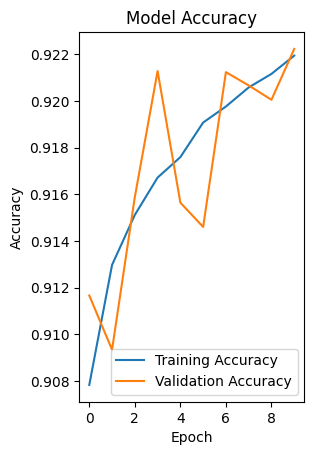

In [ ]:
import matplotlib.pyplot as plt
import json
from datetime import datetime
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

# Function to plot training history
def plot_training_history(history, timestamp):
    """Plot training accuracy, loss, and AUC."""
    metrics = ['accuracy', 'loss', 'auc']
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(history[metric], label=f'Training {metric.capitalize()}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs', fontsize=16)
        plt.xlabel('Epochs', fontsize=14)
        plt.ylabel(metric.capitalize(), fontsize=14)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.savefig(f'../logs/training_history/{metric}_{timestamp}.png')  # Save plot as an image
        plt.show()

In [ ]:
# Function to evaluate model on the test dataset and save metrics
def evaluate_model_on_test(model, test_generator, timestamp):
    """Evaluate the model on the test set and save evaluation metrics."""
    print("\nEvaluating the model on the test set...")
    test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=1)

    # Predict labels and get confusion matrix and classification report
    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    confusion = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys())

    # Save evaluation metrics
    eval_metrics = {
        "test_loss": test_loss,
        "test_accuracy": test_accuracy,
        "test_auc": test_auc,
        "confusion_matrix": confusion.tolist(),
        "classification_report": report,
    }
    with open(f'../logs/evaluation_metrics/evaluation_{timestamp}.json', 'w') as f:
        json.dump(eval_metrics, f)

    # Print evaluation results
    print("\nTest Set Evaluation Results:")
    print(f"Loss: {test_loss:.4f}")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"AUC: {test_auc:.4f}")
    print("\nClassification Report:")
    print(report)
    print("\nConfusion Matrix:")
    print(confusion)

    return eval_metrics

In [ ]:
# Define timestamp for filenames
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")


Evaluating model on test set...
661/661 ━━━━━━━━━━━━━━━━━━━━ 321s 486ms/step - accuracy: 0.9185 - auc: 0.8360 - loss: 0.2335


In [ ]:
evaluate_model_on_test(model, test_generator, timestamp)
print("\nAll tasks completed!")


Training completed!
Test Accuracy: 0.9207
Test AUC: 0.8412

Files saved:
- Model: ../models/deepfake_detector_20241106_195343.h5
- Training history: ../logs/training_history/history_20241106_195343.json
- Training curves: evaluation/training_curves_20241106_195343.png
- Evaluation results: evaluation/evaluation_results_20241106_195343.json
